In [1]:
# 参考: PyTorchでMNIST  https://qiita.com/fukuit/items/215ef75113d97560e599
# 学習用に60,000個、検証用に10,000個 28x28ピクセル

In [2]:
# データ準備

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import os
import sys
import pprint
sys.path.append(os.path.abspath('../../../dataset'))
# pprint.pprint(sys.path)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])
trainset = torchvision.datasets.MNIST(root='../../../dataset', 
                                        train=True,
                                        download=False,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=100,
                                            shuffle=True,
                                            num_workers=2)

testset = torchvision.datasets.MNIST(root='../../../dataset', 
                                        train=False, 
                                        download=False, 
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=100,
                                            shuffle=False, 
                                            num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2dはデフォルトでstride=1,padding=0、
        # MaxPool2dはデフォルトでstride=kernel_size,padding=0なので、
        # マップ一枚の縦の長さは畳み込み層を通る度に-2、プーリング層を通る度に1/2となる
        # 引数は順番に、サンプル数、チャネル数、フィルタのサイズ
        # チャネル数1→32→64
        self.conv1 = nn.Conv2d(1, 32, 3) # 28x28x32 -> 26x26x32  
        self.conv2 = nn.Conv2d(32, 64, 3) # 26x26x64 -> 24x24x64 
        self.pool = nn.MaxPool2d(2, 2) # 24x24x64 -> 12x12x64  # サイズが1/2となる
        self.dropout1 = nn.Dropout2d()
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.dropout2 = nn.Dropout2d()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 12 * 12 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [4]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [5]:
epochs = 3
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[{:d}, {:5d}] loss: {:.3f}'
                    .format(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.214
[1,   200] loss: 1.525
[1,   300] loss: 0.798
[1,   400] loss: 0.615
[1,   500] loss: 0.514
[1,   600] loss: 0.470
[2,   100] loss: 0.436
[2,   200] loss: 0.423
[2,   300] loss: 0.393
[2,   400] loss: 0.373
[2,   500] loss: 0.335
[2,   600] loss: 0.344
[3,   100] loss: 0.314
[3,   200] loss: 0.325
[3,   300] loss: 0.308
[3,   400] loss: 0.299
[3,   500] loss: 0.311
[3,   600] loss: 0.293
Finished Training


In [6]:
correct = 0
total = 0

with torch.no_grad():
    for (images, labels) in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: {:.2f} %%'.format(100 * float(correct/total)))


Accuracy: 92.26 %%


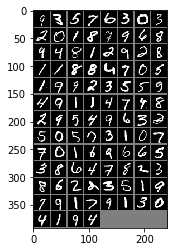

    9     3     5     7     6     3     0     3     2     0


In [7]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))
